In [19]:
import sklearn
from sklearn.datasets import make_circles
import pandas as pd
import matplotlib.pyplot as plt
import torch

In [20]:
n_samples = 1000

X, y = make_circles(n_samples, noise=0.03, random_state=42)

In [21]:
circles = pd.DataFrame({"X1": X[:, 0], 
                        "X2": X[:, 1],
                        "label": y})

circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


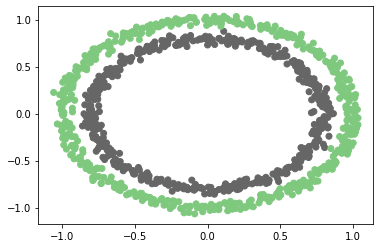

In [22]:
plt.scatter(x=X[:, 0],
            y=X[:, 1],
            c=y,
            cmap=plt.cm.Accent)

### 1.1 Check input and output shapes

In [23]:
X.shape, y.shape

((1000, 2), (1000,))

In [24]:
X_sample = X[0]
y_sample = y[0]

X_sample, X_sample.shape, y_sample, y_sample.shape

(array([0.75424625, 0.23148074]), (2,), 1, ())

### 1.2 Turn data into tensors

In [25]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

In [26]:
X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

#### Train and test sets (random split)

In [27]:
from sklearn.model_selection import train_test_split

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

### 2. Building a model

In [29]:
from torch import nn
#device = "cuda" if torch.cuda.is_available else "cpu"

In [30]:
# 1. Construct a model that subclasses nn.Module

class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        # 2. Create 2 nn.Linear layers capable of handling the shapes of our data
        self.layer_1 = nn.Linear(in_features=2, out_features=5) # takes in 2 features, upscales to 5 features (more features = more opportunities for pattern recognition)
        self.layer_2 = nn.Linear(in_features=5, out_features=1) # takes in the 5 features, outputs a single feature (same shape as y)

    # 3. Define a forward() method that outlines the forward pass
    def forward(self, x):
        return self.layer_2(self.layer_1(x)) # x -> layer1 -> layer2 -> output


# 4. Instantiate an instance of our model class and send it to the target device
model_0 = CircleModelV0() #.to(device) -> to use GPU if available
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [31]:
# Replicating the model using nn.Sequential

model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
) #.to(device)

model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[-0.0829, -0.2872],
                      [ 0.4691, -0.5582],
                      [-0.3260, -0.1997],
                      [-0.4252,  0.0667],
                      [-0.6984,  0.6386]])),
             ('0.bias', tensor([-0.6007,  0.5459,  0.1177, -0.2296,  0.4370])),
             ('1.weight',
              tensor([[ 0.0697,  0.3613,  0.0489, -0.1410,  0.1202]])),
             ('1.bias', tensor([-0.1213]))])

In [32]:
# Make predictions
with torch.inference_mode():
    untrained_preds = model_0(X_test)

### 2.1 Setup loss function and optimizer

For classification you may want to us binary cross entropy or categorical cross entropy

In [33]:
# Loss function
loss_fn = nn.BCEWithLogitsLoss() # sigmoid activation function built in, BCELoss requires inputs to have gone through the sigmoid activation layer

optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.1)

In [34]:
# Calculate accuracy - out of 100 examples, what % does our model get right?
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct/len(y_pred)) * 100
    return acc

### 3. Train model

1. Forward Pass
2. Calculate the loss
3. Optimizer zero grad
4. Loss backward
5. Optimizer step

### 3.1 Going from raw logits to prediction probabilities to prediction labels


In [35]:
# View the first 5 outputs of forward pass on the test data
model_0.eval()

with torch.inference_mode():
    y_logits = model_0(X_test)[:5]

y_logits

tensor([[ 0.3313],
        [-0.0892],
        [ 0.1742],
        [ 0.2560],
        [ 0.2966]])

In [36]:
y_test[:5]

tensor([0., 0., 1., 0., 1.])

In [37]:
# Use sigmoid activation function on our model logits to turn them into prediction probabilities
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.5821],
        [0.4777],
        [0.5434],
        [0.5637],
        [0.5736]])

In [38]:
# Find the predicted labels
y_preds = torch.round(y_pred_probs)

# In full (logits -> pred probs -> pred labels)
y_preds_lables = torch.round(torch.sigmoid(model_0(X_test)[:5]))

# Check for equality
print(torch.eq(y_preds.squeeze(), y_preds_lables.squeeze()))

# Get rid of extra dimension
y_preds.squeeze()

tensor([True, True, True, True, True])


tensor([1., 0., 1., 1., 1.])

### 3.2 Train and test loop

In [39]:
torch.manual_seed(42) # torch.cuda.manual_seed(42)

# Set number of epochs
epochs = 1000

# Build training and eval loop
for epoch in range(epochs):
    # Training
    model_0.train()

    # Forward pass
    y_logits = model_0(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # turn logits -> pred probs -> pred labels

    # Calculate loss/accuracy
    loss = loss_fn(y_logits, y_train) # BCEWithLogitsLoss expects raw logits as input
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

    # Optimizer zero grad
    optimizer.zero_grad()

    # Loss backward - backpropagation
    loss.backward()

    # Optimizer step - gradient descent
    optimizer.step()

    # Testing
    model_0.eval()
    with torch.inference_mode():
        # Forward pass
        test_logits = model_0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        # Calculate test loss/accuracy
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

        # Print out what's happening
        if epoch % 10 == 0:
            print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")


Epoch: 0 | Loss: 0.69518, Acc: 54.00% | Test loss: 0.70534, Test acc: 48.50%
Epoch: 10 | Loss: 0.69415, Acc: 53.00% | Test loss: 0.70234, Test acc: 49.00%
Epoch: 20 | Loss: 0.69366, Acc: 52.50% | Test loss: 0.70053, Test acc: 48.50%
Epoch: 30 | Loss: 0.69339, Acc: 52.25% | Test loss: 0.69935, Test acc: 49.00%
Epoch: 40 | Loss: 0.69322, Acc: 52.38% | Test loss: 0.69854, Test acc: 48.50%
Epoch: 50 | Loss: 0.69312, Acc: 52.25% | Test loss: 0.69796, Test acc: 47.50%
Epoch: 60 | Loss: 0.69305, Acc: 52.25% | Test loss: 0.69753, Test acc: 47.50%
Epoch: 70 | Loss: 0.69300, Acc: 52.38% | Test loss: 0.69720, Test acc: 48.00%
Epoch: 80 | Loss: 0.69296, Acc: 52.25% | Test loss: 0.69694, Test acc: 49.00%
Epoch: 90 | Loss: 0.69294, Acc: 52.12% | Test loss: 0.69673, Test acc: 49.00%
Epoch: 100 | Loss: 0.69292, Acc: 52.25% | Test loss: 0.69656, Test acc: 49.00%
Epoch: 110 | Loss: 0.69291, Acc: 52.38% | Test loss: 0.69643, Test acc: 49.50%
Epoch: 120 | Loss: 0.69290, Acc: 52.25% | Test loss: 0.69631, T

### 4. Make predictions and evaluate the model

Looks like the model isn't learning, lets make some predictions and visualize them to see what's going on

In [40]:
import requests
from pathlib import Path 

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

helper_functions.py already exists, skipping download


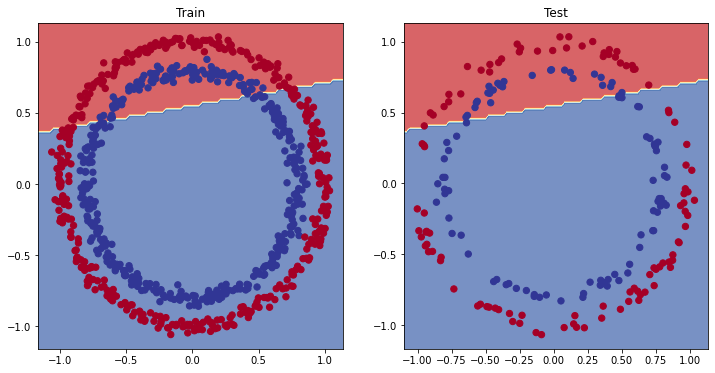

In [41]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

### 5. Improving the model (from the model's perspective)

1. Add more layers - give model more chances to learn about patterns in the data
2. Add more hidden units - go from 5 to 10 
3. Fit for longer
4. Changing activation functions
5. Change the learning rate
6. Change the loss function

In [42]:
# Improving model by adding more hidden units, more layers, and more epochs (this is not a good approach since there is not way to track the experiment)

class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
    
    def forward(self, x):
        # z = self.layer_1(x)
        # z = self.layer_2(z)
        # z = self.layer_3(z)
        return self.layer_3(self.layer_2(self.layer_1(x))) # leverage speedups where possible behind the scenes
    
model_1 = CircleModelV1()

In [43]:
# Loss function
loss_fn = nn.BCEWithLogitsLoss() # sigmoid activation function built in, BCELoss requires inputs to have gone through the sigmoid activation layer
# Optimizer
optimizer = torch.optim.SGD(params=model_1.parameters(), lr=0.1)

In [44]:
torch.manual_seed(42) # torch.cuda.manual_seed(42)

# Set number of epochs
epochs = 1000

# Build training and eval loop
for epoch in range(epochs):
    # Training
    model_1.train()

    # Forward pass
    y_logits = model_1(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # turn logits -> pred probs -> pred labels

    # Calculate loss/accuracy
    loss = loss_fn(y_logits, y_train) # BCEWithLogitsLoss expects raw logits as input
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

    # Optimizer zero grad
    optimizer.zero_grad()

    # Loss backward - backpropagation
    loss.backward()

    # Optimizer step - gradient descent
    optimizer.step()

    # Testing
    model_1.eval()
    with torch.inference_mode():
        # Forward pass
        test_logits = model_1(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        # Calculate test loss/accuracys
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

        # Print out what's happening
        if epoch % 100 == 0:
            print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69364, Acc: 51.25% | Test loss: 0.69390, Test acc: 50.00%
Epoch: 100 | Loss: 0.69292, Acc: 54.87% | Test loss: 0.69506, Test acc: 52.00%
Epoch: 200 | Loss: 0.69288, Acc: 53.62% | Test loss: 0.69548, Test acc: 51.50%
Epoch: 300 | Loss: 0.69288, Acc: 53.50% | Test loss: 0.69560, Test acc: 51.00%
Epoch: 400 | Loss: 0.69288, Acc: 53.12% | Test loss: 0.69563, Test acc: 51.50%
Epoch: 500 | Loss: 0.69288, Acc: 53.25% | Test loss: 0.69564, Test acc: 51.50%
Epoch: 600 | Loss: 0.69288, Acc: 53.25% | Test loss: 0.69564, Test acc: 51.50%
Epoch: 700 | Loss: 0.69288, Acc: 53.25% | Test loss: 0.69565, Test acc: 51.50%
Epoch: 800 | Loss: 0.69288, Acc: 53.25% | Test loss: 0.69565, Test acc: 51.50%
Epoch: 900 | Loss: 0.69288, Acc: 53.25% | Test loss: 0.69565, Test acc: 51.50%


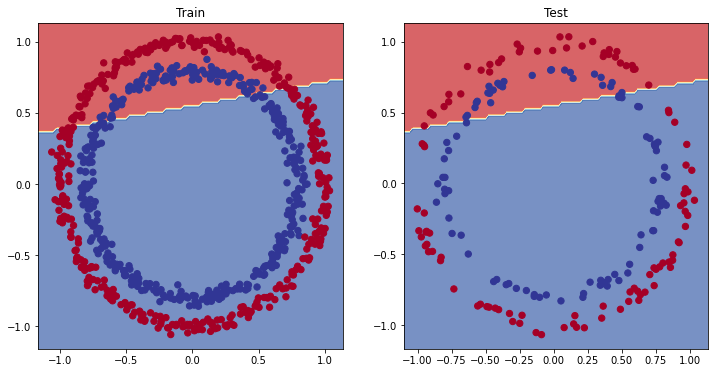

In [45]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

### 5.1 See if our model can fit a linear data set

One waay to troubleshoot is to test the model on a smaller problem

In [46]:
# Create some data 
weight = 0.7
bias = 0.3
start = 0
end = 1
step = 0.01

X_regression = torch.arange(start, end, step).unsqueeze(dim=1)
y_regression = weight * X_regression + bias

# Check data
print(len(X_regression))
X_regression[:5], y_regression[:5]

100


(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400]]),
 tensor([[0.3000],
         [0.3070],
         [0.3140],
         [0.3210],
         [0.3280]]))

In [47]:
# Train test split
train_split = int(0.8 * len(X_regression))
X_train_regression, y_train_regression = X_regression[:train_split], y_regression[:train_split]
X_test_regression, y_test_regression = X_regression[train_split:], y_regression[train_split:]

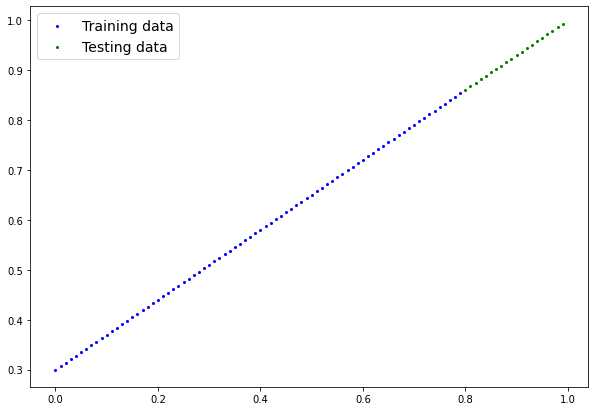

In [48]:
plot_predictions(train_data=X_train_regression, train_labels=y_train_regression, test_data=X_test_regression, test_labels=y_test_regression)

### 5.2 Adjusting model to fit straight line

In [49]:
# Same architecture as model_1 
model_2 = nn.Sequential(
    nn.Linear(in_features=1, out_features=10),
    nn.Linear(in_features=10, out_features=10),
    nn.Linear(in_features=10, out_features=1)
)

model_2

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [50]:
# Loss and optimizer
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(model_2.parameters(), lr=0.01)

In [51]:
# Train the model
torch.manual_seed(42)

epochs = 1500

for epoch in range(epochs): 
    model_2.train()
    y_pred = model_2(X_train_regression)
    loss = loss_fn(y_pred, y_train_regression)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model_2.eval()
    with torch.inference_mode():
        test_pred = model_2(X_test_regression)
        test_loss = loss_fn(test_pred, y_test_regression)

    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f} | Test loss: {test_loss:.5f}")

Epoch: 0 | Loss: 0.75986 | Test loss: 0.91103
Epoch: 100 | Loss: 0.02858 | Test loss: 0.00081
Epoch: 200 | Loss: 0.02533 | Test loss: 0.00209
Epoch: 300 | Loss: 0.02137 | Test loss: 0.00305
Epoch: 400 | Loss: 0.01964 | Test loss: 0.00341
Epoch: 500 | Loss: 0.01940 | Test loss: 0.00387
Epoch: 600 | Loss: 0.01903 | Test loss: 0.00379
Epoch: 700 | Loss: 0.01878 | Test loss: 0.00381
Epoch: 800 | Loss: 0.01840 | Test loss: 0.00329
Epoch: 900 | Loss: 0.01798 | Test loss: 0.00360
Epoch: 1000 | Loss: 0.01782 | Test loss: 0.00333
Epoch: 1100 | Loss: 0.01674 | Test loss: 0.00317
Epoch: 1200 | Loss: 0.01640 | Test loss: 0.00316
Epoch: 1300 | Loss: 0.01648 | Test loss: 0.00256
Epoch: 1400 | Loss: 0.01648 | Test loss: 0.00323


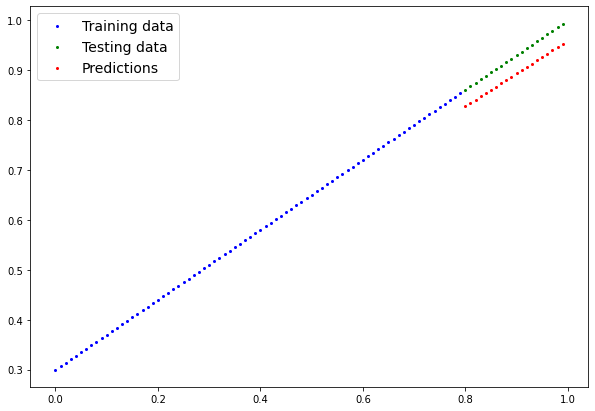

In [52]:
# Turn on evaluation mode
model_2.eval()

# Make predictions (inference)
with torch.inference_mode():
    y_preds = model_2(X_test_regression)

# Plot
plot_predictions(train_data=X_train_regression, 
                 train_labels=y_train_regression, 
                 test_data=X_test_regression, 
                 test_labels=y_test_regression, 
                 predictions=y_preds)


## The missing piece is non-linearity

### 6.1 Recreating non-linear data (red and blue circles)

In [53]:
n_samples = 1000

X, y = make_circles(n_samples, noise=0.03, random_state=42)

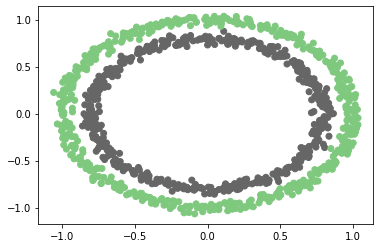

In [54]:
plt.scatter(x=X[:, 0],
            y=X[:, 1],
            c=y,
            cmap=plt.cm.Accent)

In [55]:
# Convert data to tensors + train and test split
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train[:5], y_train[:5]

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]),
 tensor([1., 0., 0., 0., 1.]))

### 6.2 Building a model with non-linearity

In [56]:
# Build model with non-linear activation functions
class CircleModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=8)
        self.layer_2 = nn.Linear(in_features=8, out_features=64)
        self.layer_3 = nn.Linear(in_features=64, out_features=1)
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))
    
model_3 = CircleModelV2()
model_3

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=8, bias=True)
  (layer_2): Linear(in_features=8, out_features=64, bias=True)
  (layer_3): Linear(in_features=64, out_features=1, bias=True)
  (relu): ReLU()
)

In [57]:
# Loss function
loss_fn = nn.BCEWithLogitsLoss() # sigmoid activation function built in, BCELoss requires inputs to have gone through the sigmoid activation layer
# Optimizer
optimizer = torch.optim.SGD(params=model_3.parameters(), lr=0.01)

In [58]:
torch.manual_seed(42)

epochs = 10000

for epoch in range(epochs):
        model_3.train()

        y_logits = model_3(X_train).squeeze()
        y_pred = torch.round(torch.sigmoid(y_logits))

        loss = loss_fn(y_logits, y_train)
        acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

        optimizer.zero_grad()
        
        loss.backward()

        optimizer.step()

        model_3.eval()
        with torch.inference_mode():
            test_logits = model_3(X_test).squeeze()
            test_pred = torch.round(torch.sigmoid(test_logits))

            test_loss = loss_fn(test_logits, y_test)
            test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

            if epoch % 1000 == 0: 
                print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69721, Acc: 50.00% | Test loss: 0.69719, Test acc: 50.00%
Epoch: 1000 | Loss: 0.68961, Acc: 59.62% | Test loss: 0.68880, Test acc: 57.00%
Epoch: 2000 | Loss: 0.68445, Acc: 65.50% | Test loss: 0.68315, Test acc: 61.50%
Epoch: 3000 | Loss: 0.67820, Acc: 63.00% | Test loss: 0.67699, Test acc: 61.50%
Epoch: 4000 | Loss: 0.66942, Acc: 62.12% | Test loss: 0.66869, Test acc: 62.00%
Epoch: 5000 | Loss: 0.65248, Acc: 68.25% | Test loss: 0.65315, Test acc: 73.00%
Epoch: 6000 | Loss: 0.62568, Acc: 80.38% | Test loss: 0.63091, Test acc: 83.00%
Epoch: 7000 | Loss: 0.57885, Acc: 92.12% | Test loss: 0.59197, Test acc: 90.50%
Epoch: 8000 | Loss: 0.49611, Acc: 96.75% | Test loss: 0.52036, Test acc: 97.00%
Epoch: 9000 | Loss: 0.37499, Acc: 99.50% | Test loss: 0.40932, Test acc: 98.00%


### 6.4 Evaluating a model trained with non-linear activation functions

In [59]:
model_3.eval()
with torch.inference_mode():
    y_preds = torch.round(torch.sigmoid(model_3(X_test))).squeeze()

y_preds[:10], y_test[:10]

(tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.]),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.]))

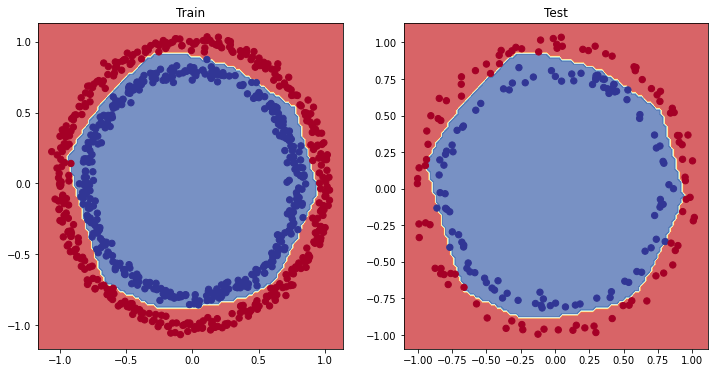

In [60]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_3, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_3, X_test, y_test)

### 7.  Replicating non-linear activation functions

In [61]:
A = torch.arange(-10, 10, 1, dtype=torch.float32)
A.dtype

torch.float32

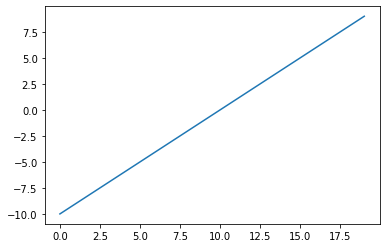

In [62]:
plt.plot(A)

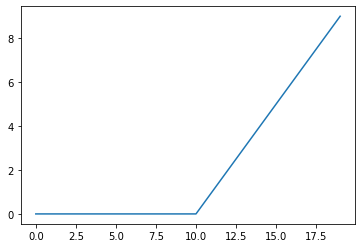

In [63]:
plt.plot(torch.relu(A))

In [64]:
def relu(x):
    return torch.max(torch.tensor(0), x)

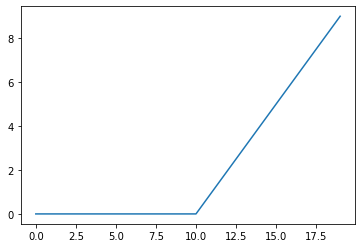

In [65]:
plt.plot(relu(A))

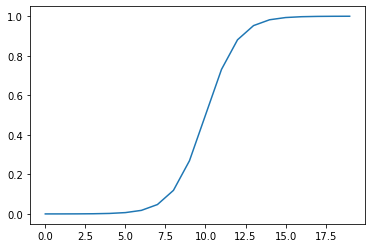

In [66]:
plt.plot(torch.sigmoid(A))

In [67]:
def sigmoid(x):
    return 1 / (1 + torch.exp(-x))

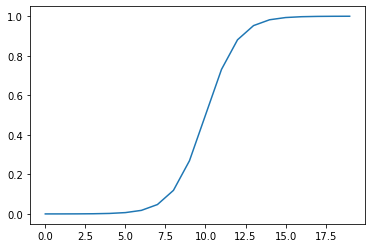

In [68]:
plt.plot(sigmoid(A))

# Multiclass Classification

In [69]:
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
import torch.nn as nn

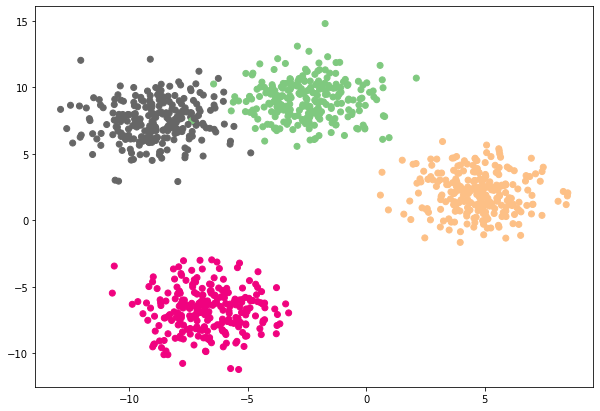

In [79]:
# Toy dataset

NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

X_blob, y_blob = make_blobs(n_samples=1000,
                            n_features=NUM_FEATURES,
                            centers=NUM_CLASSES,
                            cluster_std=1.5,
                            random_state=RANDOM_SEED)

X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)

X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob, y_blob, test_size=0.2, random_state=RANDOM_SEED)

plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.Accent)

In [80]:
class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8):
        """Initialized multi-class classification model

        Args:
            input_features (int): Number of input features to the model
            output_features (int): Number of output features/classes
            hidden_units (int): Number of hidden units between layers, default 8
        """
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_features)
        )
    
    def forward(self, x):
        return self.linear_layer_stack(x)
    
model_4 = BlobModel(input_features=2, output_features=4, hidden_units=8)

model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [81]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_4.parameters(), lr=0.1)

In [82]:
model_4.eval()
with torch.inference_mode():
    y_logits = model_4(X_blob_test)
y_logits[:10]

tensor([[-0.7646, -0.7412, -1.5777, -1.1376],
        [-0.0973, -0.9431, -0.5963, -0.1371],
        [ 0.2528, -0.2379,  0.1882, -0.0066],
        [-0.4134, -0.5204, -0.9303, -0.6963],
        [-0.3118, -1.3736, -1.1991, -0.3834],
        [-0.1497, -1.0617, -0.7107, -0.1645],
        [ 0.1539, -0.2887,  0.1520, -0.0109],
        [-0.2154, -1.1795, -0.9300, -0.2745],
        [ 0.2443, -0.2472,  0.1649,  0.0061],
        [-0.2329, -1.2120, -0.9849, -0.3004]])

In [83]:
y_blob_test[:10]

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0])

In [84]:
# Convert logits to prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)
y_pred_probs[:10]

tensor([[0.3169, 0.3244, 0.1405, 0.2182],
        [0.3336, 0.1432, 0.2026, 0.3206],
        [0.3011, 0.1843, 0.2823, 0.2323],
        [0.3078, 0.2766, 0.1836, 0.2320],
        [0.3719, 0.1286, 0.1532, 0.3463],
        [0.3381, 0.1358, 0.1929, 0.3331],
        [0.2867, 0.1841, 0.2861, 0.2431],
        [0.3554, 0.1355, 0.1740, 0.3351],
        [0.3009, 0.1841, 0.2779, 0.2371],
        [0.3595, 0.1350, 0.1695, 0.3360]])

In [85]:
# Covert probabilities to labels
y_preds = torch.argmax(y_pred_probs, dim=1)
y_preds

tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 3, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 1, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 3, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 1, 0, 1])

In [86]:
y_blob_test

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0, 0, 1, 0, 0, 0, 3, 3, 2, 3, 3, 3, 0, 1, 2,
        2, 2, 3, 0, 1, 0, 3, 1, 1, 3, 1, 2, 1, 3, 0, 2, 0, 3, 3, 2, 0, 3, 1, 1,
        0, 3, 1, 0, 1, 1, 3, 2, 1, 1, 3, 2, 2, 0, 3, 2, 2, 0, 0, 3, 3, 0, 0, 3,
        3, 3, 2, 3, 3, 3, 3, 1, 0, 2, 3, 2, 3, 3, 2, 3, 3, 2, 3, 3, 1, 3, 3, 3,
        1, 0, 3, 2, 0, 0, 3, 0, 2, 3, 1, 0, 3, 2, 1, 1, 0, 2, 2, 3, 0, 0, 1, 2,
        2, 3, 0, 1, 2, 0, 0, 0, 2, 3, 1, 2, 3, 2, 0, 3, 0, 0, 1, 1, 1, 0, 2, 2,
        2, 2, 0, 3, 3, 2, 2, 1, 3, 2, 0, 0, 3, 3, 2, 1, 2, 0, 3, 2, 0, 3, 2, 0,
        2, 2, 2, 0, 3, 1, 1, 1, 1, 1, 3, 1, 0, 2, 2, 1, 2, 2, 0, 1, 2, 2, 0, 0,
        1, 3, 2, 0, 3, 1, 2, 1])

In order to evaluate, train and test the model, we need to convert the model's output (logits) to prediction probabilities and then to prediction labels

Logits -> Pred Probs (`torch.softmax()`) -> pred lables (argmax of pred probs)

In [90]:
torch.manual_seed(42)

epochs = 100

for epoch in range(epochs):
    model_4.train()
    
    y_logits = model_4(X_blob_train)
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

    loss = loss_fn(y_logits, y_blob_train)
    acc = accuracy_fn(y_true=y_blob_train, y_pred=y_pred)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model_4.eval()
    with torch.inference_mode():
        test_logits = model_4(X_blob_test)
        test_preds = torch.softmax(test_logits, dim=1).argmax(dim=1)

        test_loss = loss_fn(test_logits, y_blob_test)
        test_acc = accuracy_fn(y_true=y_blob_test, y_pred=test_preds)

    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.03278, Acc: 99.25% | Test loss: 0.02395, Test acc: 99.50%
Epoch: 10 | Loss: 0.03134, Acc: 99.25% | Test loss: 0.02231, Test acc: 99.50%
Epoch: 20 | Loss: 0.03025, Acc: 99.25% | Test loss: 0.02103, Test acc: 99.50%
Epoch: 30 | Loss: 0.02943, Acc: 99.25% | Test loss: 0.02004, Test acc: 99.50%
Epoch: 40 | Loss: 0.02877, Acc: 99.25% | Test loss: 0.01925, Test acc: 99.50%
Epoch: 50 | Loss: 0.02823, Acc: 99.25% | Test loss: 0.01860, Test acc: 99.50%
Epoch: 60 | Loss: 0.02778, Acc: 99.25% | Test loss: 0.01805, Test acc: 99.50%
Epoch: 70 | Loss: 0.02740, Acc: 99.25% | Test loss: 0.01757, Test acc: 99.50%
Epoch: 80 | Loss: 0.02707, Acc: 99.25% | Test loss: 0.01715, Test acc: 99.50%
Epoch: 90 | Loss: 0.02678, Acc: 99.25% | Test loss: 0.01678, Test acc: 99.50%


In [91]:
# Making and evaluating predictions
model_4.eval()
with torch.inference_mode():
    y_logits = model_4(X_blob_test)

y_logits[:10]

tensor([[ -0.8300,   7.4425,  -8.6623,  -9.6590],
        [ -2.4394,  -7.2647,  -4.4885,   4.0301],
        [ -4.2021,  -4.6335,   3.9828,  -3.1939],
        [ -1.4951,   5.3074,  -4.4692,  -5.5594],
        [  4.8318,  -1.4446, -10.3272,  -8.0065],
        [ -3.1232,  -8.6560,  -5.1912,   4.7955],
        [ -3.7206,  -3.9741,   3.5085,  -2.6409],
        [  4.3105,  -4.6964,  -7.8567,  -4.0653],
        [ -5.3474,  -5.9176,   4.8558,  -4.1093],
        [  4.4939,  -3.4801,  -8.5582,  -5.3990]])

In [92]:
# logits -> prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)
y_pred_probs[:10]

tensor([[2.5538e-04, 9.9974e-01, 1.0131e-07, 3.7392e-08],
        [1.5474e-03, 1.2416e-05, 1.9937e-04, 9.9824e-01],
        [2.7850e-04, 1.8091e-04, 9.9878e-01, 7.6332e-04],
        [1.1097e-03, 9.9881e-01, 5.6698e-05, 1.9058e-05],
        [9.9812e-01, 1.8766e-03, 2.6042e-07, 2.6519e-06],
        [3.6372e-04, 1.4385e-06, 4.5988e-05, 9.9959e-01],
        [7.2274e-04, 5.6089e-04, 9.9659e-01, 2.1276e-03],
        [9.9964e-01, 1.2252e-04, 5.1965e-06, 2.3029e-04],
        [3.7047e-05, 2.0947e-05, 9.9981e-01, 1.2777e-04],
        [9.9960e-01, 3.4417e-04, 2.1448e-06, 5.0514e-05]])

In [93]:
# pred probs -> labels
y_preds = y_pred_probs.argmax(dim=1)
y_preds[:10]

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0])

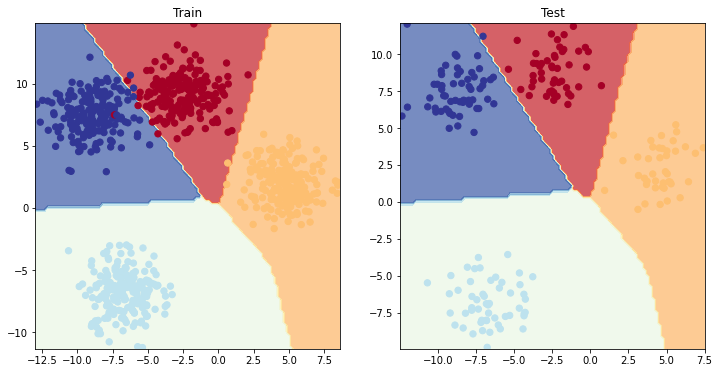

In [95]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_4, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_4, X_blob_test, y_blob_test)

### Classification Metrics (torchmetrics)

* Accuracy - not good for imbalanced classes
* Precision - higher precision = less false positive (precision recall tradeoff)
* Recall - higher recall = less false negatives
* F1-score - combines precision and recall - good overall metric
* Confusion matrix - compare predictions to labels, see where the model gets confused, hard with large numbers of classes
* Classification report